# PERFORMANCE OF HEDGED CREDIT

AUTHOR: [@sparshsah](https://github.com/sparshsah)

In [1]:
# ignore: just data loading + cleaning

import sys
# https://github.com/sparshsah/foggy-lib/tree/main/util
sys.path.insert(0, "../../../foggy-lib/util")
del sys

import pandas as pd
# https://github.com/sparshsah/foggy-lib/blob/main/util/foggy_pylib/fin.py
import foggy_pylib.fin as fin


def _read_csv(fname):
    return pd.read_csv(fname, index_col=0, parse_dates=True).sort_index().squeeze()

def _get_bond_r_from_yld(fname: str, name: str, dur: float=fin.DEFAULT_BOND_DUR, xr: bool=False) -> fin.FloatSeries:
    yld = _read_csv(fname=fname)
    yld = yld.apply(lambda y: None if y == "." else y)
    yld = yld.ffill(limit=3)
    yld = yld.astype(float)
    yld = yld / 100  # comes as pctg
    yld = yld.rename(name)
    r = fin.get_r_from_yld(yld=yld, dur=dur)
    if xr:
        r = fin.get_xr(r=r, cash_r=TBILL_R)
    return r

def get_tbill_r():
    return _get_bond_r_from_yld(fname="data/fred-3m-tbill-secondary-yld.csv", name="tbill3m", dur=0.25)

def get_ty_xr():
    return _get_bond_r_from_yld(fname="data/fred-2y-treasury-mkt-yld.csv", name="tnote2Y", dur=1.9, xr=True)

def get_mbs_xr():
    px = _read_csv("data/invesco-us-mbs-index-px.csv")
    r = fin.get_r_from_px(px=px)
    xr = fin.get_xr(r=r, cash_r=TBILL_R)
    xr = xr.rename("mbs")
    return xr

def get_spx_xr():
    px = _read_csv("data/yahoo-finance-spy-px.csv")
    px = px["Adj Close"]
    r = fin.get_r_from_px(px=px)
    xr = fin.get_xr(r=r, cash_r=TBILL_R)
    xr = xr.rename("spx")
    return xr

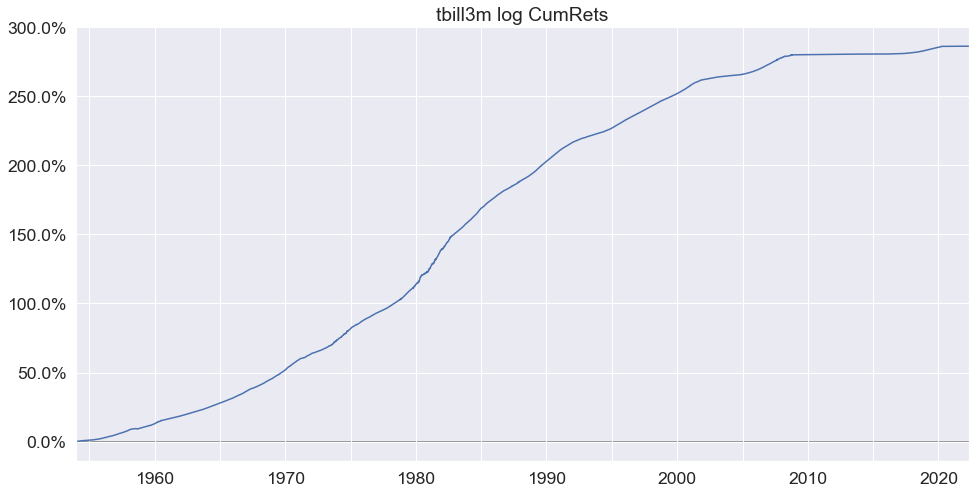

Sharpe                                  6.22
ER                                    0.0419
Vol                                   0.0067
t-stat                                 51.38
Frac valid timesteps                       1
Total valid timesteps                  17826
Total timesteps                        17827
First timestep           1954-01-04 00:00:00
First valid timestep     1954-01-05 00:00:00
Last valid timestep      2022-05-03 00:00:00
Last timestep            2022-05-03 00:00:00
dtype: object


In [2]:
TBILL_R = get_tbill_r()
fin.chart(TBILL_R)

# performance of vol-targeted passive assets

## government bonds

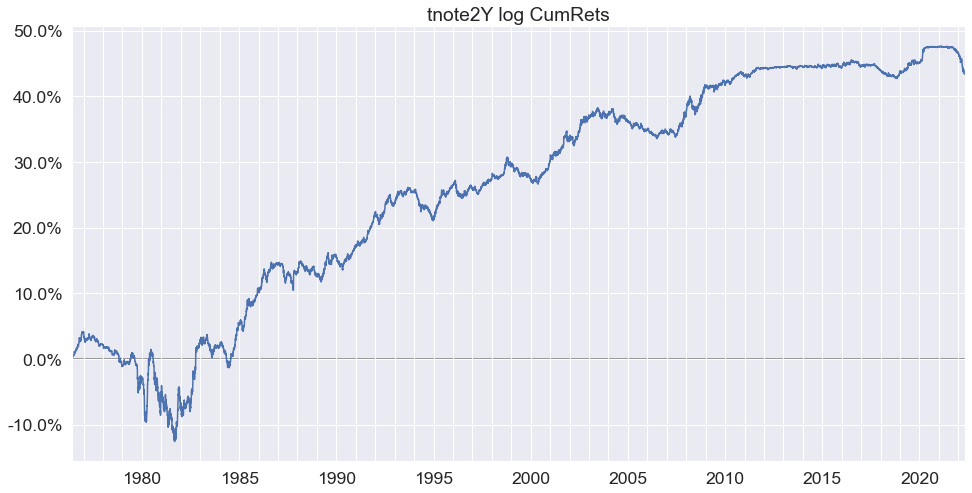

Sharpe                                  0.41
ER                                    0.0094
Vol                                   0.0232
t-stat                                  2.76
Frac valid timesteps                       1
Total valid timesteps                  11980
Total timesteps                        11983
First timestep           1976-06-01 00:00:00
First valid timestep     1976-06-02 00:00:00
Last valid timestep      2022-05-03 00:00:00
Last timestep            2022-05-05 00:00:00
dtype: object


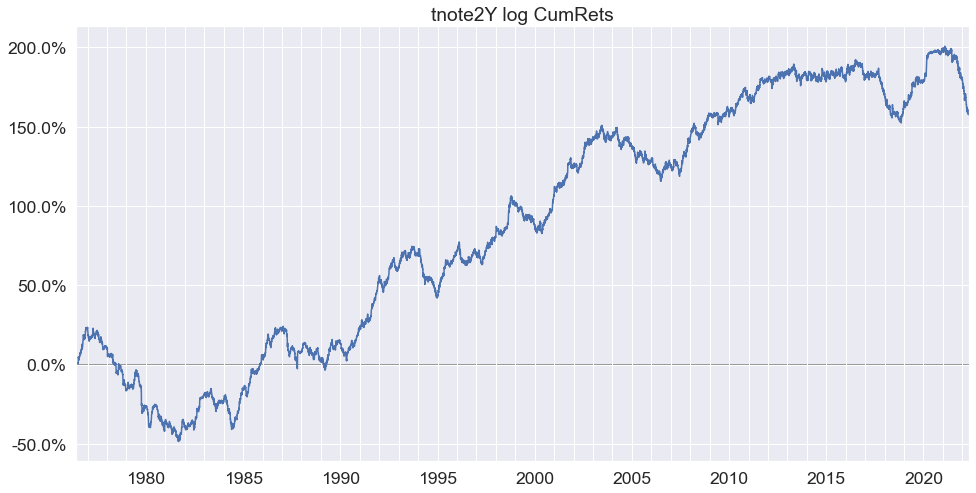

Sharpe                                  0.33
ER                                    0.0344
Vol                                   0.1053
t-stat                                  2.21
Frac valid timesteps                   0.998
Total valid timesteps                  11958
Total timesteps                        11983
First timestep           1976-06-01 00:00:00
First valid timestep     1976-07-02 00:00:00
Last valid timestep      2022-05-03 00:00:00
Last timestep            2022-05-05 00:00:00
dtype: object


In [3]:
_TY_XR = get_ty_xr()
TY_XR = fin.get_vol_targeted(xr=_TY_XR)

fin.chart(r=_TY_XR)
fin.chart(r=TY_XR)

## mortgage-backed securities

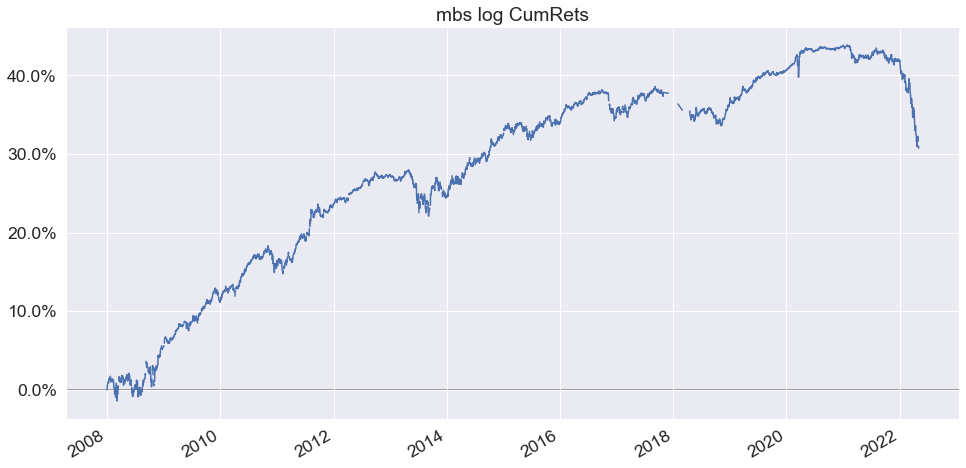

Sharpe                                  0.49
ER                                    0.0224
Vol                                   0.0455
t-stat                                  1.83
Frac valid timesteps                   0.774
Total valid timesteps                   3611
Total timesteps                         4663
First timestep           2007-12-31 00:00:00
First valid timestep     2008-01-01 00:00:00
Last valid timestep      2022-05-03 00:00:00
Last timestep            2022-05-04 00:00:00
dtype: object


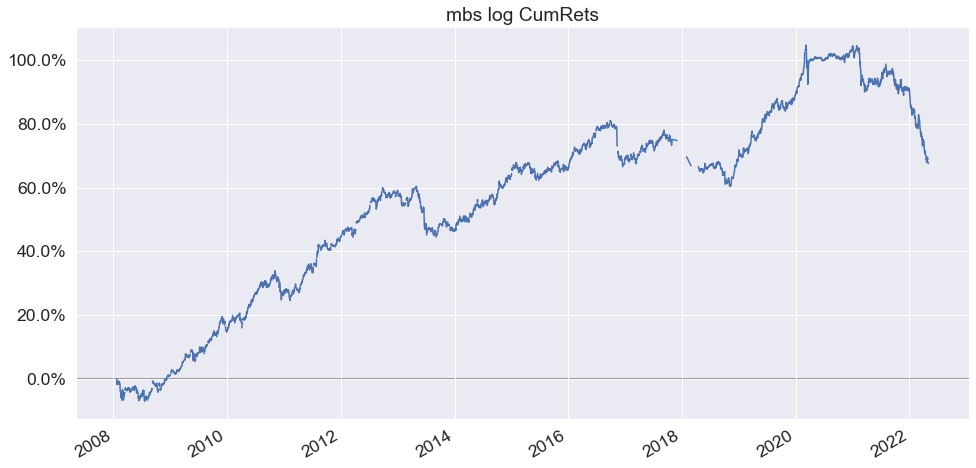

Sharpe                                  0.45
ER                                    0.0493
Vol                                   0.1093
t-stat                                  1.68
Frac valid timesteps                   0.771
Total valid timesteps                   3595
Total timesteps                         4663
First timestep           2007-12-31 00:00:00
First valid timestep     2008-01-23 00:00:00
Last valid timestep      2022-05-03 00:00:00
Last timestep            2022-05-04 00:00:00
dtype: object


In [4]:
_MBS_XR = get_mbs_xr()
MBS_XR = fin.get_vol_targeted(xr=_MBS_XR)

fin.chart(r=_MBS_XR)
fin.chart(r=MBS_XR)

## developed-market stocks

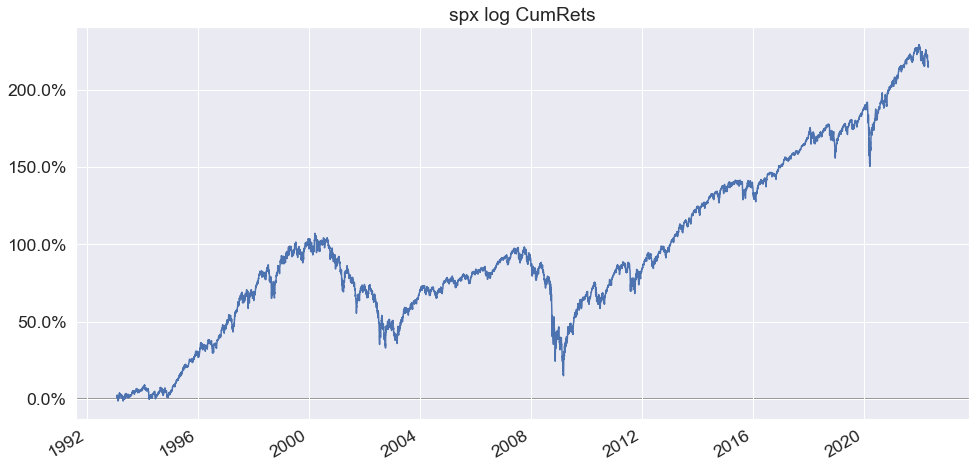

Sharpe                                  0.43
ER                                    0.0765
Vol                                   0.1789
t-stat                                  2.27
Frac valid timesteps                       1
Total valid timesteps                   7368
Total timesteps                         7370
First timestep           1993-01-29 00:00:00
First valid timestep     1993-02-01 00:00:00
Last valid timestep      2022-05-03 00:00:00
Last timestep            2022-05-04 00:00:00
dtype: object


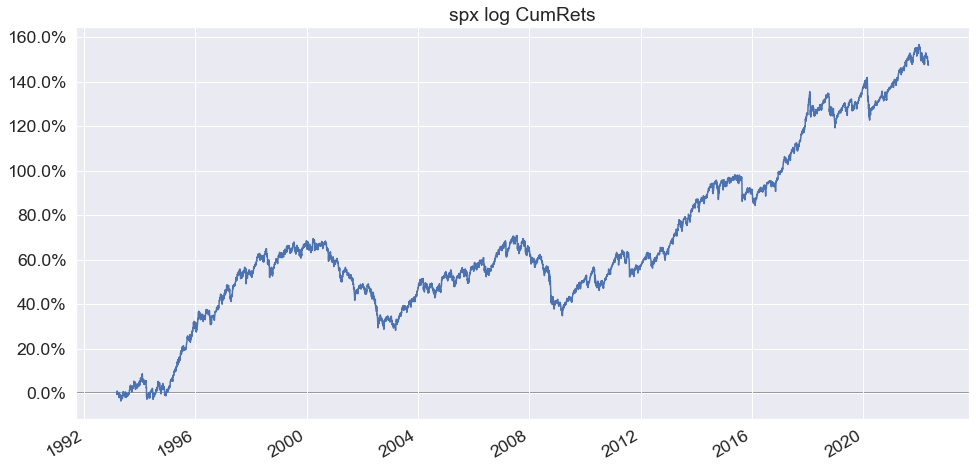

Sharpe                                   0.5
ER                                    0.0526
Vol                                   0.1053
t-stat                                  2.65
Frac valid timesteps                   0.997
Total valid timesteps                   7346
Total timesteps                         7370
First timestep           1993-01-29 00:00:00
First valid timestep     1993-03-04 00:00:00
Last valid timestep      2022-05-03 00:00:00
Last timestep            2022-05-04 00:00:00
dtype: object


In [5]:
_SPX_XR = get_spx_xr()
SPX_XR = fin.get_vol_targeted(xr=_SPX_XR)

fin.chart(r=_SPX_XR)
fin.chart(r=SPX_XR)

# performance of hedged vol-targeted mortgage-backed securities

In [6]:
fin.get_est_corr(y=MBS_XR, x=_MBS_XR)

0.8959859284673652

In [7]:
fin.get_est_corr(y=MBS_XR, x=TY_XR)

0.804608107215629

In [8]:
fin.get_est_corr(y=MBS_XR, x=SPX_XR)

-0.23188561618306558

-0.5496979260458523 0.14697704468263553
-0.4398664764080164 -0.09365372966268408


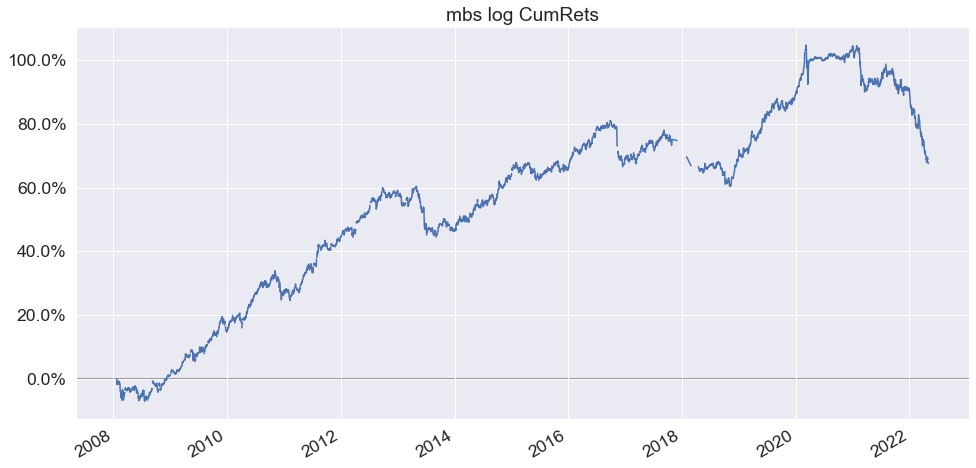

Sharpe                                  0.45
ER                                    0.0493
Vol                                   0.1093
t-stat                                  1.68
Frac valid timesteps                   0.771
Total valid timesteps                   3595
Total timesteps                         4663
First timestep           2007-12-31 00:00:00
First valid timestep     2008-01-23 00:00:00
Last valid timestep      2022-05-03 00:00:00
Last timestep            2022-05-04 00:00:00
dtype: object


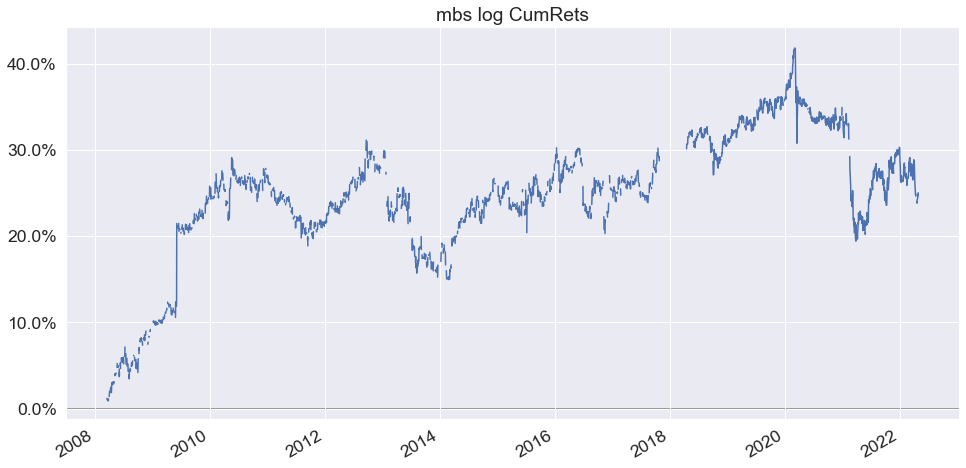

Sharpe                                  0.19
ER                                    0.0263
Vol                                   0.1363
t-stat                                  0.58
Frac valid timesteps                   0.182
Total valid timesteps                   2374
Total timesteps                        13033
First timestep           1976-06-01 00:00:00
First valid timestep     2008-03-19 00:00:00
Last valid timestep      2022-05-02 00:00:00
Last timestep            2022-05-05 00:00:00
dtype: object


In [9]:
MBSH_XR = fin.get_hedged(base_xr=MBS_XR, hedge_xr=TY_XR)
print(fin.get_est_corr(y=MBSH_XR, x=TY_XR), fin.get_est_corr(y=MBSH_XR, x=SPX_XR))

MBSH_XR = fin.get_hedged(base_xr=MBSH_XR, hedge_xr=SPX_XR)
print(fin.get_est_corr(y=MBSH_XR, x=TY_XR), fin.get_est_corr(y=MBSH_XR, x=SPX_XR))

fin.chart(r=MBS_XR)
fin.chart(r=MBSH_XR)